In [27]:
import warnings

import gensim
import nltk
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import textdistance
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from optuna.pruners import SuccessiveHalvingPruner
from sentence_transformers import SentenceTransformer, util
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    auc,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from tqdm import tqdm
from wordcloud import WordCloud

warnings.filterwarnings("ignore")

In [28]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmytro.miedviediev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dmytro.miedviediev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# check if m1 gpu available

import torch

print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

device = torch.device("mps")
device

True
True


device(type='mps')

In [51]:
train = pd.concat(
    [
        pd.read_csv("../datasets/train_extended.csv"),
        pd.read_csv("../datasets/naive_bayes_labeled_final.csv")[
            pd.read_csv("../datasets/naive_bayes_labeled_final.csv")[
                "Suspicious_Level"
            ].isin([3])
        ],
        pd.read_csv("../datasets/naive_bayes_labeled_final2.csv")[
            pd.read_csv("../datasets/naive_bayes_labeled_final2.csv")[
                "Suspicious_Level"
            ].isin([3])
        ],
        pd.read_csv("../datasets/naive_bayes_labeled_additional.csv")[
            pd.read_csv("../datasets/naive_bayes_labeled_additional.csv")[
                "Suspicious_Level"
            ].isin([3])
        ],
        pd.read_csv("../datasets/naive_bayes_labeled_final2.csv")[
            pd.read_csv("../datasets/naive_bayes_labeled_final2.csv")[
                "Suspicious_Level"
            ].isin([2])
        ],
        pd.read_csv("../datasets/naive_bayes_labeled_additional.csv")[
            pd.read_csv("../datasets/naive_bayes_labeled_additional.csv")[
                "Suspicious_Level"
            ].isin([2])
        ][:100],
        pd.read_csv("../datasets/naive_bayes_labeled_final2.csv")[
            pd.read_csv("../datasets/naive_bayes_labeled_final2.csv")[
                "Suspicious_Level"
            ].isin([1])
        ][:500],
        pd.read_csv("../datasets/naive_bayes_labeled_additional.csv")[
            pd.read_csv("../datasets/naive_bayes_labeled_additional.csv")[
                "Suspicious_Level"
            ].isin([1])
        ][:500],
    ]
)
test = pd.read_csv("../datasets/test_extended.csv")

In [52]:
train["Suspicious_Level"].value_counts()

Suspicious_Level
1    1383
2     680
3     470
Name: count, dtype: int64

In [53]:
train = train.drop_duplicates(subset="Content", keep="first")

In [54]:
# initialize stop words
stop_words = stopwords.words("russian")

In [55]:
# text processing section
def remove_stop_words(text, join_back=True):
    result = []
    for token in word_tokenize(text.lower()):
        if token not in stop_words and token.isalpha():
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result


def preprocess(text, join_back=True):
    res = remove_stop_words(text, join_back)
    return res

In [56]:
X = train["Content"].values
y = train["Suspicious_Level"].values

In [57]:
from imblearn.over_sampling import SMOTE

In [58]:
random_state = 42
test_size = 0.2


class DisinformationPredictor:
    def __init__(self, vectorizer, model, n_splits=5):
        self.vectorizer = vectorizer
        self.model = model
        self.skf = StratifiedKFold(
            n_splits=n_splits, random_state=random_state, shuffle=True
        )

    def encode(self, X):
        return self.vectorizer.transform(X)

    def fit_encode(self, X):
        return self.vectorizer.fit_transform(X)

    def validate(self, X, y, visualize=True):
        scores = cross_validate(
            self.model,
            X,
            y,
            cv=self.skf,
            scoring=("f1_weighted", "f1_macro"),
            verbose=0,
            return_estimator=True,
            return_train_score=False,
        )
        # get top results
        top_index = np.argmax(scores["test_f1_macro"])
        self.model = scores["estimator"][top_index]
        del scores["estimator"]
        return pd.DataFrame(scores).loc[top_index]

    def fit(self, X, y):
        self.model.fit(X, y)
        return f1_score(y, self.model.predict(X), average="macro")

    def predict(self, X):
        return self.model.predict(X)

In [105]:
bag_of_words_predictor = DisinformationPredictor(
    vectorizer=CountVectorizer(
        analyzer="word",
        preprocessor=preprocess,
        # ngram_range=(1, 2),
    ),
    model=LogisticRegression(class_weight="balanced"),
)

bag_of_words_encoded = bag_of_words_predictor.fit_encode(X)
bag_of_words_encoded

<2322x30204 sparse matrix of type '<class 'numpy.int64'>'
	with 116928 stored elements in Compressed Sparse Row format>

In [106]:
model1 = MultinomialNB()
model2 = SVC(kernel="linear", class_weight="balanced")
model3 = SVC(kernel="poly", class_weight="balanced")
model4 = SVC(kernel="rbf", class_weight="balanced")
model5 = LogisticRegression(class_weight="balanced")

# Create an ensemble of models
ensemble_model = VotingClassifier(
    estimators=[
        ("nb", model1),
        ("svm", model2),
        ("lr", model5),
        ("svm2", model3),
        ("svm3", model4),
    ],
    voting="hard",
)

ensemble_predictor = DisinformationPredictor(
    vectorizer=CountVectorizer(
        analyzer="word",
        preprocessor=preprocess,
        ngram_range=(1, 2),
    ),
    model=ensemble_model,
)

bag_of_words_encoded_ensemble = ensemble_predictor.fit_encode(X)
bag_of_words_encoded_ensemble

<2322x125531 sparse matrix of type '<class 'numpy.int64'>'
	with 242044 stored elements in Compressed Sparse Row format>

In [94]:
tfidf_predictor = DisinformationPredictor(
    vectorizer=TfidfVectorizer(
        analyzer="word", preprocessor=preprocess, ngram_range=(1, 2), norm="l2"
    ),
    model=SVC(class_weight="balanced"),
)

tfidf_encoded = tfidf_predictor.fit_encode(X)
tfidf_encoded

<2322x125531 sparse matrix of type '<class 'numpy.float64'>'
	with 242044 stored elements in Compressed Sparse Row format>

In [95]:
sent_tr = SentenceTransformer("all-MiniLM-L12-v2", device=device)
sent_tr.transform = lambda x: sent_tr.encode(x, show_progress_bar=True, device=device)
sent_tr.fit_transform = sent_tr.transform

sent_transformer_predictor = DisinformationPredictor(
    vectorizer=sent_tr,
    model=SVC(class_weight="balanced"),
)

sent_encoded = sent_transformer_predictor.fit_encode(X)

Batches: 100%|████████████████████████████████████████████████████████████████████████████| 73/73 [00:08<00:00,  9.08it/s]


In [107]:
scores = []
predictors = zip(
    [bag_of_words_predictor],
    [bag_of_words_encoded],
)
for predictor, embeddings in predictors:
    # sm = SMOTE(random_state=42, k_neighbors=7, sampling_strategy="auto")
    embeddings_x, y_y = embeddings, y  # sm.fit_resample(embeddings, y)
    scores.append(predictor.validate(embeddings_x, y_y))
scores = pd.DataFrame(scores)
scores

,fit_time,score_time,test_f1_weighted,test_f1_macro
3,0.712131,0.001661,0.898757,0.887385


In [108]:
X_test = test["Content"].values.astype(str)
X_test_encoded = bag_of_words_predictor.encode(X_test)

y = train["Suspicious_Level"].values
print(bag_of_words_predictor.fit(bag_of_words_encoded, y))
test["Suspicious_Level"] = bag_of_words_predictor.predict(X_test_encoded)

0.999312492215718


In [109]:
submission = test[["MessageId", "Suspicious_Level"]]
submission

,MessageId,Suspicious_Level
0,168641,1
1,36569,1
2,19697,1
3,49296,3
4,11784,1
...,...,...
1166,47454,1
1167,214788,1
1168,122190,1
1169,19610,1


In [112]:
submission.to_csv("../datasets/multinominal_submission_fail.csv", index=False)

In [113]:
submission[
    submission["Suspicious_Level"]
    != pd.read_csv("../datasets/naive_bayes_laplace_normalised.csv")["Suspicious_Level"]
]["Suspicious_Level"].value_counts()

Suspicious_Level
3    101
1     85
2     74
Name: count, dtype: int64

## Additional

In [253]:
def objective(trial):
    bag_of_words_predictor = DisinformationPredictor(
        vectorizer=CountVectorizer(
            analyzer="word",
            preprocessor=preprocess,
            ngram_range=(1, 2),
            max_features=max_features,
        ),
        model=LogisticRegression(
            max_iter=10000,
        ),
    )

    bag_of_words_encoded = bag_of_words_predictor.fit_encode(X)
    bag_of_words_encoded

    return bag_of_words_predictor.validate(embeddings, y)["test_f1_macro"]

In [251]:
def tune():
    # 1. Pruner
    pruner = SuccessiveHalvingPruner(
        min_resource=1, reduction_factor=2, min_early_stopping_rate=0
    )

    # 2. Create a Study Object
    study = optuna.create_study(pruner=pruner, direction="maximize")

    # 3. Run the Optimization Process
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Print best hyperparameters and corresponding F1 score
    print("Best trial:")
    trial = study.best_trial
    print(f"Value: {trial.value}")
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study, trial.params

In [252]:
study, params = tune()

[I 2023-11-19 00:35:31,111] A new study created in memory with name: no-name-fa3a576b-ca21-4d1f-b4ee-e1e9849fe01c
[I 2023-11-19 00:35:31,583] Trial 0 finished with value: 0.4011435718752792 and parameters: {'max_features': 693}. Best is trial 0 with value: 0.4011435718752792.
[I 2023-11-19 00:35:32,013] Trial 1 finished with value: 0.4011435718752792 and parameters: {'max_features': 173}. Best is trial 0 with value: 0.4011435718752792.
[I 2023-11-19 00:35:32,443] Trial 2 finished with value: 0.4011435718752792 and parameters: {'max_features': 771}. Best is trial 0 with value: 0.4011435718752792.
[I 2023-11-19 00:35:32,875] Trial 3 finished with value: 0.4011435718752792 and parameters: {'max_features': 868}. Best is trial 0 with value: 0.4011435718752792.
[I 2023-11-19 00:35:33,306] Trial 4 finished with value: 0.4011435718752792 and parameters: {'max_features': 364}. Best is trial 0 with value: 0.4011435718752792.
[I 2023-11-19 00:35:33,737] Trial 5 finished with value: 0.401143571875

KeyboardInterrupt: 

In [352]:
test[[0, 1, 2]] = pd.DataFrame(
    bag_of_words_predictor.model.predict_proba(X_test_encoded)
)

In [353]:
test.to_csv("test_linear_regression.csv", index=False)

## Unsupervised

In [175]:
unsupervised_data = pd.read_csv("../datasets/filtered_unsupervised_data2.0.csv")

In [176]:
X_unsupervised = unsupervised_data["Content"].values.astype(str)
X_unsupervised = bag_of_words_predictor.encode(X_unsupervised)

y = train["Suspicious_Level"].values
print(bag_of_words_predictor.fit(bag_of_words_encoded, y))

1.0


In [177]:
unsupervised_data[[0, 1, 2]] = bag_of_words_predictor.model.predict_proba(
    X_unsupervised
)
unsupervised_data["Suspicious_Level"] = bag_of_words_predictor.model.predict(
    X_unsupervised
)

In [178]:
unsupervised_data_selected = unsupervised_data[
    (unsupervised_data[0] >= 0.95)
    | (unsupervised_data[1] >= 0.85)
    | (unsupervised_data[2] >= 0.7)
]
unsupervised_data_selected

,ChannelName,Date,Content,0,1,2,Suspicious_Level
154,zpnewsru,2023-10-01 09:07:22.000,Балицкий поздравил военнослужащих с Днем сухоп...,0.968080,0.019237,0.012683,1
161,zpnewsru,2023-10-01 08:35:20.000,Балицкий: Бойцы сухопутных войск дают отпор ог...,0.967809,0.013144,0.019046,1
282,crossnews_ru,2023-10-01 07:15:12.000,Великое национальное собрание (парламент) Турц...,0.972306,0.019685,0.008009,1
825,vesticrimea,2023-10-01 07:44:07.000,"❗️ Над Джанкоем сбили ракету, сообщил глава Кр...",0.959174,0.023008,0.017818,1
928,rt_ru_news,2023-10-01 09:43:13.000,Эрдоган назвал взрыв около здания МВД Турции «...,0.985001,0.010422,0.004577,1
...,...,...,...,...,...,...,...
79195,zspecialnews,2023-10-26 13:16:01.000,"""Иксоводы"" 336 гвардейской бригады морской пех...",0.087213,0.869853,0.042934,2
79209,bfmnews,2023-10-26 14:07:08.000,"В Кремле заявили, что тренировка стратегически...",0.966073,0.014463,0.019464,1
79311,russiancanadiannews,2023-10-26 12:41:38.000,‼️🇷🇺Героические кадры: наш разведчик при штурм...,0.079456,0.894481,0.026063,2
80671,rgrunews,2023-10-27 11:03:02.000,"""Это - вопрос, быть нашей стране или не быть""\...",0.952632,0.023009,0.024359,1


In [16]:
import pandas as pd
import textdistance


def similarity_ratio(str1, str2):
    return textdistance.jaccard(str1, str2)


def drop_similar_duplicates(df, text_column, similarity_threshold=0.9):
    df_copy = df.copy()
    df_copy["DuplicateFlag"] = False

    for i, row in tqdm(df_copy.iterrows()):
        if not df_copy.at[i, "DuplicateFlag"]:
            current_text = row[text_column]
            df_copy["Similarity"] = df_copy[text_column].apply(
                lambda x: similarity_ratio(current_text, x)
            )
            duplicates = df_copy[
                df_copy["Similarity"] >= similarity_threshold
            ].index.tolist()

            # Mark duplicates as True in 'DuplicateFlag' column using loc
            df_copy.loc[
                duplicates[:-1], "DuplicateFlag"
            ] = True  # Keep the last occurrence

    # Drop rows marked as duplicates
    df_copy = df_copy[df_copy["DuplicateFlag"] == False]

    # Drop the temporary columns
    df_copy = df_copy.drop(["DuplicateFlag", "Similarity"], axis=1)

    return df_copy


# Drop duplicates based on 90% similarity
# unsupervised_data_selected = drop_similar_duplicates(
#     unsupervised_data_selected, "Content", similarity_threshold=0.8
# )

In [180]:
unsupervised_data_selected

,ChannelName,Date,Content,0,1,2,Suspicious_Level
154,zpnewsru,2023-10-01 09:07:22.000,Балицкий поздравил военнослужащих с Днем сухоп...,0.968080,0.019237,0.012683,1
161,zpnewsru,2023-10-01 08:35:20.000,Балицкий: Бойцы сухопутных войск дают отпор ог...,0.967809,0.013144,0.019046,1
282,crossnews_ru,2023-10-01 07:15:12.000,Великое национальное собрание (парламент) Турц...,0.972306,0.019685,0.008009,1
825,vesticrimea,2023-10-01 07:44:07.000,"❗️ Над Джанкоем сбили ракету, сообщил глава Кр...",0.959174,0.023008,0.017818,1
928,rt_ru_news,2023-10-01 09:43:13.000,Эрдоган назвал взрыв около здания МВД Турции «...,0.985001,0.010422,0.004577,1
...,...,...,...,...,...,...,...
79195,zspecialnews,2023-10-26 13:16:01.000,"""Иксоводы"" 336 гвардейской бригады морской пех...",0.087213,0.869853,0.042934,2
79209,bfmnews,2023-10-26 14:07:08.000,"В Кремле заявили, что тренировка стратегически...",0.966073,0.014463,0.019464,1
79311,russiancanadiannews,2023-10-26 12:41:38.000,‼️🇷🇺Героические кадры: наш разведчик при штурм...,0.079456,0.894481,0.026063,2
80671,rgrunews,2023-10-27 11:03:02.000,"""Это - вопрос, быть нашей стране или не быть""\...",0.952632,0.023009,0.024359,1


In [181]:
unsupervised_data_selected[
    ["ChannelName", "Date", "Content", "Suspicious_Level"]
].to_csv("../datasets/unsupervised_labeled_linear2.csv", index=False)

## Filter unsupervised

In [6]:
unsupervised_data = pd.read_csv("../datasets/unsupervised_data.csv")
unsupervised_data = unsupervised_data.dropna()

In [7]:
test["ChannelName"].value_counts()[:30]

ChannelName
solovievlive          172
ukraina_ru            109
rian_ru                95
tass_agency            92
stranaua               87
denazi_ua              65
uanotru                48
donbassr               45
openukraine            44
readovkanews           42
voenacher              36
istorijaoruzijaz       28
bear007                21
newsfrontnotes         21
asupersharij           21
sheptoon               18
notes_veterans         15
gardez66               15
zerada1                15
rezident_ua            13
zakharprilepin         13
voenkorkotenok         12
kremlin_sekret         11
rsotmdivision          11
spletnicca             11
za_derjavy             10
readovkaru              9
tsibulya_ua             8
zola_of_renovation      8
montyan2                8
Name: count, dtype: int64

In [8]:
filtered_try2 = unsupervised_data[
    (
        unsupervised_data["ChannelName"].str.lower().str.contains("live")
        | unsupervised_data["ChannelName"].str.lower().str.contains("ua")
        | unsupervised_data["ChannelName"].str.lower().str.contains("ria")
        | unsupervised_data["ChannelName"].str.lower().str.contains("tass")
        | unsupervised_data["ChannelName"].str.lower().str.contains("strana")
        | unsupervised_data["ChannelName"].str.lower().str.contains("denazi")
        | unsupervised_data["ChannelName"].str.lower().str.contains("donba")
        | unsupervised_data["ChannelName"].str.lower().str.contains("agency")
        | unsupervised_data["ChannelName"].str.lower().str.contains("news")
        | unsupervised_data["ChannelName"].str.lower().str.contains("front")
        | unsupervised_data["ChannelName"].str.lower().str.contains("rezident")
        | unsupervised_data["ChannelName"].str.lower().str.contains("splet")
        | unsupervised_data["ChannelName"].str.lower().str.contains("ze")
        | unsupervised_data["ChannelName"].str.lower().str.contains("azov")
        | unsupervised_data["ChannelName"].str.lower().str.contains("kotenok")
        | unsupervised_data["ChannelName"].str.lower().str.contains("kotenok")
    )
    & ~(
        unsupervised_data["ChannelName"].str.lower().str.contains("chat")
        | unsupervised_data["ChannelName"].str.lower().str.contains("comment")
        | unsupervised_data["ChannelName"].str.lower().str.contains("hze7fcbzsdhnzm0")
        | unsupervised_data["ChannelName"].str.lower().str.contains("kor2")
        | unsupervised_data["ChannelName"].str.lower().str.contains("discuss")
        | unsupervised_data["ChannelName"]
        .str.lower()
        .str.contains("refugeesinswitzerland")
        | unsupervised_data["ChannelName"].str.lower().str.contains("ru2chnews")
        | unsupervised_data["ChannelName"].str.lower().str.contains("amplify")
        | unsupervised_data["ChannelName"]
        .str.lower()
        .str.contains("rss_tass_en_rt_fr_not_offical")
        | unsupervised_data["ChannelName"].str.lower().str.contains("okolofnews")
        | unsupervised_data["ChannelName"].str.lower().str.contains("ukraineat")
        | unsupervised_data["ChannelName"].str.lower().str.contains("ukrnastup")
        | unsupervised_data["ChannelName"].str.lower().str.contains("islamicfront99")
        | unsupervised_data["ChannelName"].str.lower().str.contains("franceukraine")
        | unsupervised_data["ChannelName"].str.lower().str.contains("ukrainereality")
        | unsupervised_data["ChannelName"].str.lower().str.contains("donbassnew1")
        | unsupervised_data["ChannelName"]
        .str.lower()
        .str.contains("the_rusian_front_onli")
    )
]

In [24]:
filtered_try2 = filtered_try2[
    (filtered_try2["Content"].str.len() >= 200)
    & (filtered_try2["Content"].str.len() <= 700)
]

In [18]:
filtered_try2 = filtered_try2.drop_duplicates(subset="Content", keep="first")

In [25]:
filtered_try2

,ChannelName,Date,Content
143,nikitinaraskazet,2023-10-01 21:00:39.000,"В ГОСДУМЕ ОБЪЯСНИЛИ, ЗА КАКИЕ ПОСТРОЙКИ НА ДАЧ..."
2162,evacuationukraine,2023-10-01 02:44:51.000,1 жовтня – День захисників і захисниць України...
2418,nashdonbass,2023-10-01 02:42:22.000,Вот так выглядело начало Второй Мировой Войны....
2452,nashdonbass,2023-10-01 01:28:44.000,Дмитрий Медведев в своём поздравлении с Днём В...
2551,russiancanadiannews,2023-10-01 02:24:50.000,⚡️⚡️ Вот и подключились украинские лоббисты в ...
...,...,...,...
15681816,newsvladivostok,2023-10-27 01:22:24.000,"Господя, а зачем ему это делать? \nМоя подруга..."
15681834,newsby_info,2023-10-27 03:01:37.000,☑️ Главные новости на утро 27 октября:\n\n🔹СШ...
15681846,tengrinews,2023-10-27 02:53:11.000,Экс-депутат маслихата Актобе Сания Муратова ар...
15681852,tengrinews,2023-10-27 01:44:36.000,Некоторые подробности задержания Марата Бекета...


In [20]:
filtered_try2 = drop_similar_duplicates(
    filtered_try2, "Content", similarity_threshold=0.8
)

4it [00:50, 12.55s/it]


KeyboardInterrupt: 

In [ ]:
filtered_try2["ChannelName"].value_counts()

In [26]:
filtered_try2.to_csv("../datasets/last_try_new_data.csv", index=False)

In [21]:
filtered_unsupervised = unsupervised_data[
    (unsupervised_data["Content"].str.len() > 200)
    & (unsupervised_data["Content"].str.len() < 600)
]
filtered_unsupervised = filtered_unsupervised.drop_duplicates(
    subset="Content", keep="first"
)
filtered_unsupervised

KeyboardInterrupt: 

In [159]:
filtered_unsupervised = filtered_unsupervised[
    (
        filtered_unsupervised["ChannelName"].str.lower().str.contains("news")
        | filtered_unsupervised["ChannelName"].str.lower().str.contains("vesti")
    )
    & ~(
        filtered_unsupervised["ChannelName"].str.lower().str.contains("ua")
        | filtered_unsupervised["ChannelName"].str.lower().str.contains("uk")
        | filtered_unsupervised["ChannelName"].str.lower().str.contains("ukraine")
        | filtered_unsupervised["ChannelName"].str.lower().str.contains("baraholka")
        | filtered_unsupervised["ChannelName"].str.lower().str.contains("comment")
        | filtered_unsupervised["ChannelName"]
        .str.lower()
        .str.contains("monitoring_arktika")
        | filtered_unsupervised["ChannelName"]
        .str.lower()
        .str.contains("hze7fcbzsdhnzm0")
    )
]

In [160]:
filtered_unsupervised

,ChannelName,Date,Content
2551,russiancanadiannews,2023-10-01 02:24:50.000,⚡️⚡️ Вот и подключились украинские лоббисты в ...
2651,vesticrimea,2023-10-01 03:00:00.000,📚 Ещё 140 управленцев из новых регионов изучил...
2657,vesticrimea,2023-10-01 02:31:30.000,🇷🇺 Республика Крым активно способствует интегр...
2681,crimeanewscom,2023-10-01 03:15:26.000,В Крыму проходит молодёжный форум «Россия – эт...
3048,ostashkonews,2023-10-01 00:24:07.000,🇦🇿🇦🇲 Азербайджан демонстрирует новую партию за...
...,...,...,...
15681776,newsvladivostok,2023-10-27 00:26:48.000,"Из за первоночалки и процентной ставки,постоян..."
15681780,newsvladivostok,2023-10-27 03:09:21.000,"Расскажи мне, половая щель, как и где ВСРЗ рем..."
15681816,newsvladivostok,2023-10-27 01:22:24.000,"Господя, а зачем ему это делать? \nМоя подруга..."
15681834,newsby_info,2023-10-27 03:01:37.000,☑️ Главные новости на утро 27 октября:\n\n🔹СШ...


In [161]:
filtered_unsupervised.to_csv("filtered_unsupervised_data2.0.csv", index=False)

In [27]:
from bertopic import BERTopic
from hdbscan import HDBSCAN

vectorizer_model = CountVectorizer(stop_words=stop_words, preprocessor=preprocess)
hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
    min_samples=20,
)

topic_model = BERTopic(
    embedding_model="paraphrase-multilingual-mpnet-base-v2",
    verbose=True,
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    min_topic_size=20,
)

topics, probs = topic_model.fit_transform(test["Content"].to_list())

Batches: 100%|████████████████████████████████████████████████████████████████████████████| 37/37 [02:39<00:00,  4.31s/it]
2023-11-19 06:37:28,100 - BERTopic - Transformed documents to Embeddings
2023-11-19 06:37:30,054 - BERTopic - Reduced dimensionality
2023-11-19 06:37:30,076 - BERTopic - Clustered reduced embeddings


In [28]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,450,-1_это_сша_россии_заявил,"[это, сша, россии, заявил, время, года, которы...","[""Счастливого конца не будет"", - заявил Зеленс..."
1,0,155,0_всу_направлении_районе_области,"[всу, направлении, районе, области, противник,...",[❗️ Главное из нового брифинга Минобороны Росс...
2,1,146,1_это_россии_лет_всем,"[это, россии, лет, всем, году, всё, людей, кот...",[ДУМНЫЕ ДЬЯКИ И ЖЕЛЕЗНЫЙ ФЕЛИКС\n\nНа установл...
3,2,91,2_это_украины_зеленский_украине,"[это, украины, зеленский, украине, сша, войну,...","[Вы только посмотрите, что Зеленский наговорил..."
4,3,72,3_ким_чен_ын_кндр,"[ким, чен, ын, кндр, путин, россию, путина, вс...",[❗️Лидер КНДР Ким Чен Ын по приглашению Путина...
5,4,63,4_выборы_выборах_выборов_регионах,"[выборы, выборах, выборов, регионах, лдпр, гол...",[Выборы глав регионов были самыми неконкурентн...
6,5,34,5_коррупцию_деньги_украины_зеленского,"[коррупцию, деньги, украины, зеленского, прези...",[Глава фракции «Слуга народа» Давид Арахамия н...
7,6,31,6_армении_армян_азербайджана_армии,"[армении, армян, азербайджана, армии, арменией...",[Пашинян последовательно уничтожает Армению. Т...
8,7,29,7_суд_колонии_режима_натаров,"[суд, колонии, режима, натаров, строгого, приг...",[⚡️⚡️Высокопоставленный педофил-коррупционер п...
9,8,28,8_курс_рублей_цб_рост,"[курс, рублей, цб, рост, рубля, уровне, руб, д...",[Кабмин прогнозирует курс доллара в следующем ...


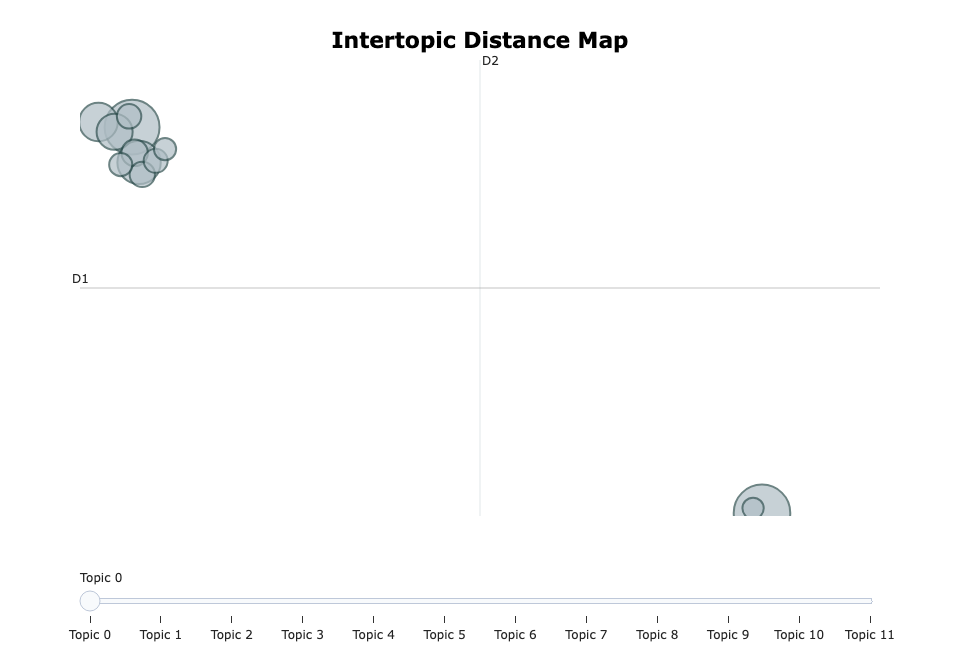

In [29]:
topic_model.visualize_topics()